In [1]:
import sys 
import os
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
import pandas as pd
import seaborn as sns
from pathlib import Path
from utils.mlflow_query import MlflowHelper
from utils.percentiles import calculate_accuracies_per_percentiles, plot_accuracies_per_percentiles

In [2]:
percentile_names=[
    'avg_input_frequencies_percentile', 
    'median_input_frequencies_percentile', 
    'min_input_frequencies_percentile', 
    'p10_input_frequencies_percentile', 
    'unknown_inputs_percentile', 
    'output_frequency_percentile',
    'avg_input_frequencies_range', 
    'median_input_frequencies_range', 
    'min_input_frequencies_range', 
    'p10_input_frequencies_range', 
    'unknown_inputs_range', 
    "unclustered_inputs_percentile",
    "unclustered_inputs_perc_percentile",
    "clustered_inputs_percentile",
    "clustered_inputs_perc_percentile",
    "single_clustered_inputs_percentile",
    "single_clustered_inputs_perc_percentile",
    "single_clustered_inputs_clusterperc_percentile",
    "multi_clustered_inputs_percentile",
    "multi_clustered_inputs_perc_percentile",
    "multi_clustered_inputs_clusterperc_percentile",
    "avg_cluster_input_frequency_percentile",
    "median_cluster_input_frequency_percentile",
    "unclustered_inputs_range",
    "unclustered_inputs_perc_range",
    "clustered_inputs_range",
    "clustered_inputs_perc_range",
    "single_clustered_inputs_range",
    "single_clustered_inputs_perc_range",
    "single_clustered_inputs_clusterperc_range",
    "multi_clustered_inputs_range",
    "multi_clustered_inputs_perc_range",
    "multi_clustered_inputs_clusterperc_range",
    "avg_cluster_input_frequency_range",
    "median_cluster_input_frequency_range",
]

In [3]:
mlflow_helper = MlflowHelper(pkl_file=Path("mlflow_run_df.pkl"), 
    local_mlflow_dir_prefix='/home/i40/almasrirz/Domain-Guided-Monitoring/mlruns/', 
    experiment_id="831333387297563441")
mlflow_helper.query_runs()

Initialized with 213 MLFlow runs from pkl


Querying data per run...: 100%|██████████| 333/333 [00:02<00:00, 137.54it/s]


In [7]:
def plot_best_metric_bar(metric_df, metric_names,
    x_feature_name='data_tags_model_type', 
    x_order=['simple', 'causal_heuristic', 'causal_score'],
    save_fig = False,
    row_feature_name=None,
    hue_feature_name=None,
    col_feature_name=None,
    titles=None,
    palette=None,
    dodge=True,
    col_order=None
):
    for metric_name in metric_names:
        g = sns.catplot(
            data=metric_df, x=x_feature_name, y=metric_name, order=x_order,
            row=row_feature_name, hue=hue_feature_name, col=col_feature_name, col_order=col_order,
            kind="box", sharey='row', palette=palette, dodge=dodge,
        )
        g.set_titles(titles).set_axis_labels('', metric_name)
        for ax in g.axes.flatten():
            ax.tick_params(labelbottom=True)
        if save_fig:
            g.savefig("bar_{}.png".format(metric_name))


### Comparing Score Algorithm with Timestamps vs no timestamps

In [5]:
run_df = mlflow_helper.run_df[
    (mlflow_helper.run_df['data_params_ExperimentConfigmax_data_size'] == '-1')
    & ((mlflow_helper.run_df['data_tags_model_type'] == 'causal_score')
    | (mlflow_helper.run_df['data_tags_model_type'] == "simple"))
]
run_df = mlflow_helper.load_best_metrics_for_ids(set(run_df["info_run_id"]))

Querying metrics for runs: 100%|██████████| 152/152 [00:10<00:00, 14.99it/s]


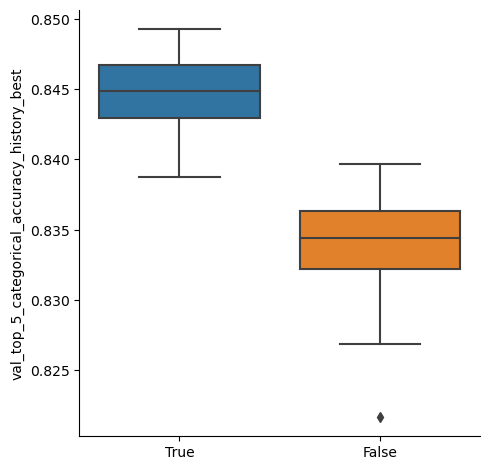

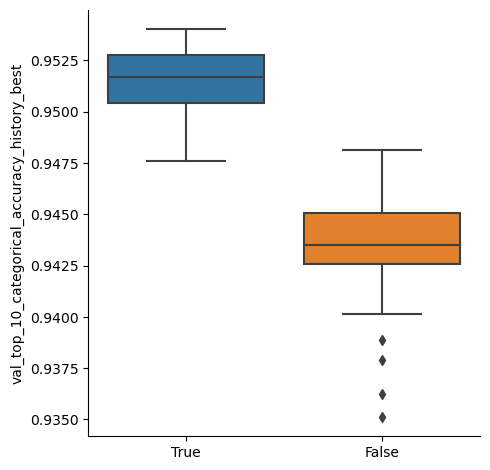

In [6]:
# Score algorithm with timestamp vs no timestamp
plot_best_metric_bar(run_df, ['val_top_5_categorical_accuracy_history_best', 'val_top_10_categorical_accuracy_history_best'],
    x_feature_name='data_params_HuaweiPreprocessorConfigremove_dates_from_payload',
    x_order=['True', 'False'], # True = no timestamps, False = with timestamps
    titles= "Score algorithm {x_feature_name}"
)

In [7]:
# accuracy_df = calculate_accuracies_per_percentiles(
#    relevant_run_df=run_df, k=5, num_percentiles=10, num_input_percentiles=10,
#    percentile_names=percentile_names,
#    local_mlflow_dir=mlflow_helper.local_mlflow_dir)
accuracy_df = pd.read_csv('/home/i40/almasrirz/Domain-Guided-Monitoring/data/percentile_accuracy_score_simple.csv')

In [30]:
# To get the plot to show, I appended simple results with timestamps not
# removed because my original results had the param set to True. Keeping or
# removing timestamps doesn't matter though for the simple case
relevant_run_df = run_df.copy()
simple_df = relevant_run_df.copy().loc[relevant_run_df['data_tags_model_type'] == 'simple', :]
simple_df.loc[:,'data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] = 'False'
relevant_run_df = pd.concat([relevant_run_df, simple_df])

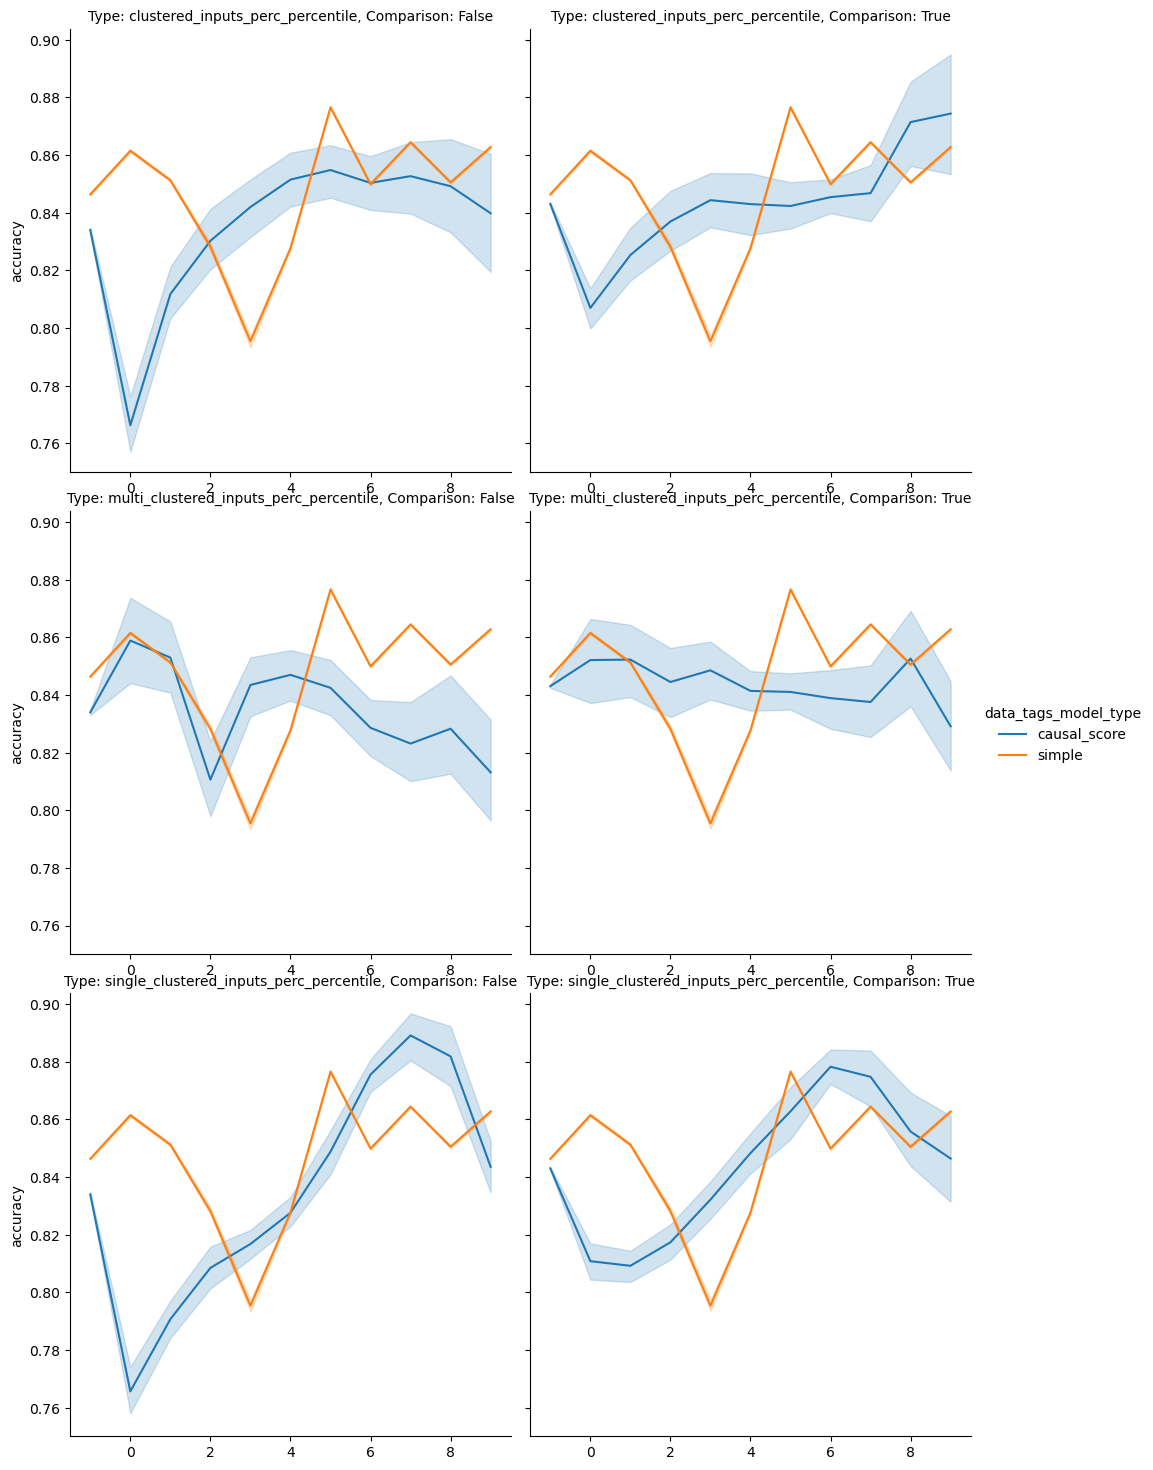

{'False', 'True'}


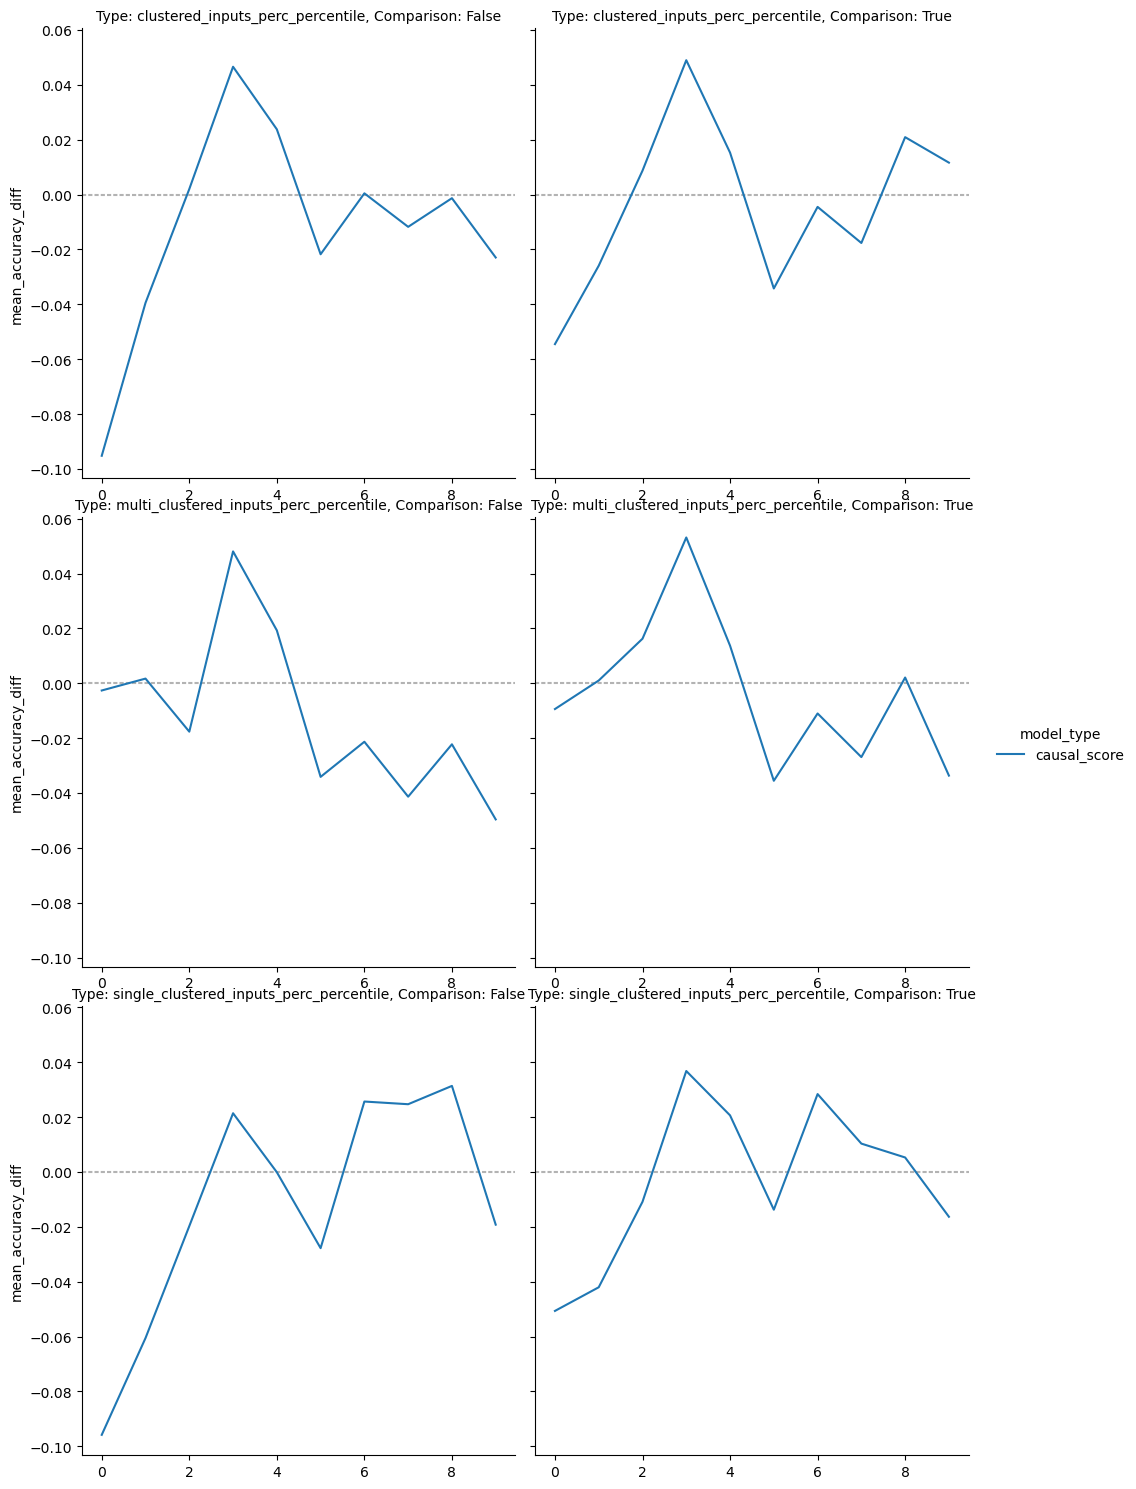

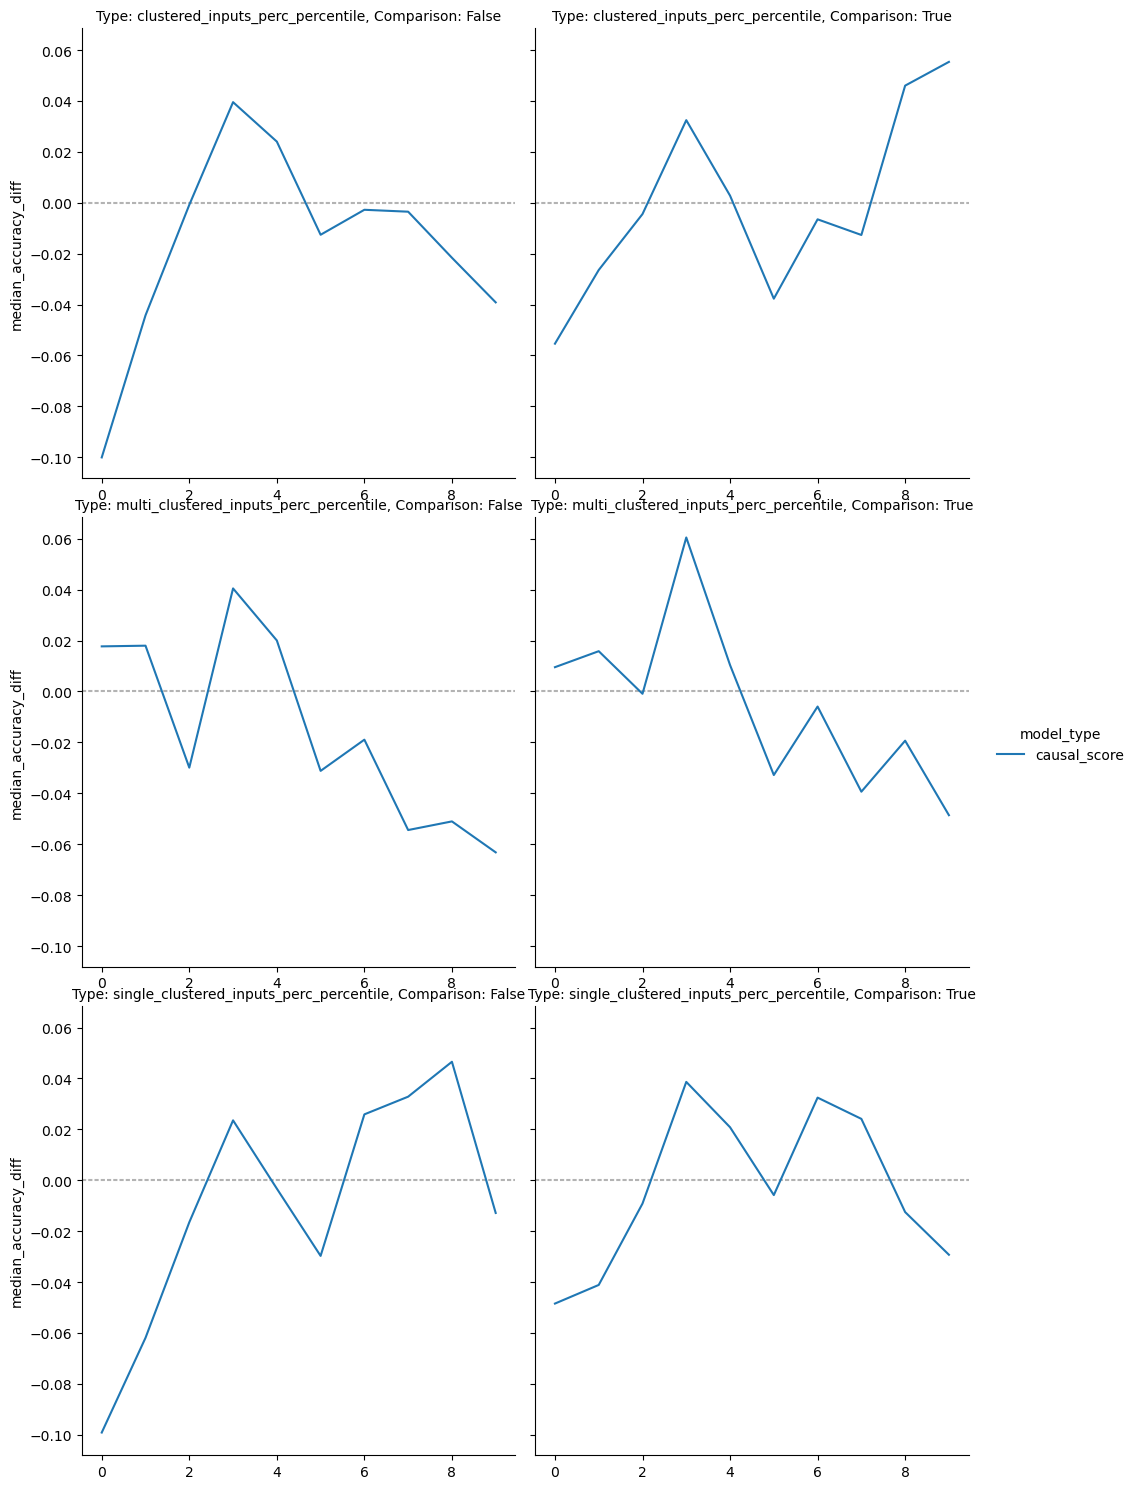

In [31]:
plot_accuracies_per_percentiles(
    relevant_run_df=relevant_run_df, 
    accuracy_df=accuracy_df[
        accuracy_df["type"].apply(lambda x: x in [
            "clustered_inputs_perc_percentile",
            "single_clustered_inputs_perc_percentile",
            "multi_clustered_inputs_perc_percentile"
        ])    
    ],
    show_plot=True,
    share_y=True,
    comparison_column="data_params_HuaweiPreprocessorConfigremove_dates_from_payload",
    algorithm_types=["causal_score"]
)

### CCDr vs Score vs Simple

In [8]:
run_df = mlflow_helper.run_df[
    (mlflow_helper.run_df['data_params_ExperimentConfigmax_data_size'] == '-1')
    & (mlflow_helper.run_df['data_tags_model_type'].isin(['causal_score', 'causal_CCDr', 'simple']))
]
run_df = mlflow_helper.load_best_metrics_for_ids(set(run_df["info_run_id"]))

Querying metrics for runs: 100%|██████████| 260/260 [00:17<00:00, 15.17it/s]


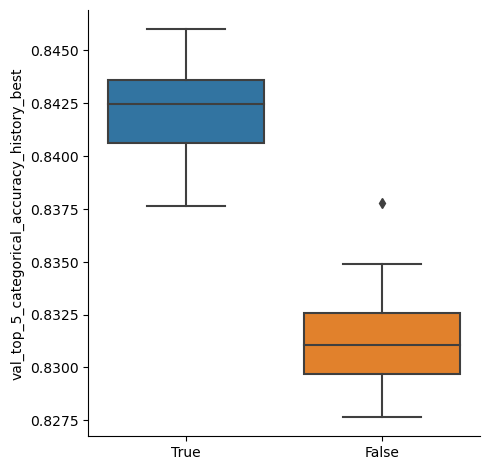

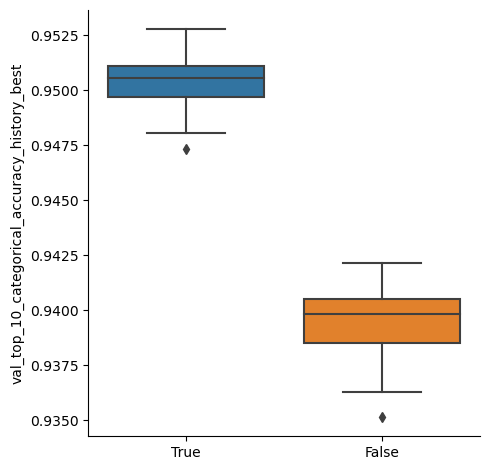

In [9]:
# CCDr algorithm with timestamp vs no timestamp
ccdr_df = run_df[run_df['data_tags_model_type'] == 'causal_CCDr']
plot_best_metric_bar(ccdr_df, ['val_top_5_categorical_accuracy_history_best', 'val_top_10_categorical_accuracy_history_best'],
    x_feature_name='data_params_HuaweiPreprocessorConfigremove_dates_from_payload',
    x_order=['True', 'False'], # True = no timestamps, False = with timestamps
    titles= "CCDr algorithm {x_feature_name}"
)

In [10]:
# accuracy_df = calculate_accuracies_per_percentiles(
#    relevant_run_df=run_df, k=5, num_percentiles=10, num_input_percentiles=10,
#    percentile_names=percentile_names,
#    local_mlflow_dir=mlflow_helper.local_mlflow_dir)
accuracy_df = pd.read_csv('/home/i40/almasrirz/Domain-Guided-Monitoring/data/percentile_accuracy_ccdr_score_simple_ts_nots.csv')

Calculating accuracy@k per percentile:  96%|█████████▌| 250/260 [1:29:05<03:38, 21.83s/it]

No attention file for run 709e2e104725461daef8935e0de2bc73 in local MlFlow dir
No attention file for run 709e2e104725461daef8935e0de2bc73 in local MlFlow dir


Calculating accuracy@k per percentile:  97%|█████████▋| 251/260 [1:29:26<03:13, 21.48s/it]

No attention file for run c6160c4fd3e74d758387ad4a7b6c3ffe in local MlFlow dir
No attention file for run c6160c4fd3e74d758387ad4a7b6c3ffe in local MlFlow dir


Calculating accuracy@k per percentile:  97%|█████████▋| 253/260 [1:30:07<02:27, 21.11s/it]

No attention file for run 699ec67c859b4d0ebdf5786f64819bec in local MlFlow dir
No attention file for run 699ec67c859b4d0ebdf5786f64819bec in local MlFlow dir


Calculating accuracy@k per percentile: 100%|██████████| 260/260 [1:32:35<00:00, 21.37s/it]


In [11]:
# To get the plot to show, I appended simple results with timestamps not
# removed because my original results had the param set to True. Keeping or
# removing timestamps doesn't matter though for the simple case
relevant_run_df = run_df.copy()
simple_df = relevant_run_df.copy().loc[relevant_run_df['data_tags_model_type'] == 'simple', :]
simple_df.loc[:,'data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] = 'False'
relevant_run_df = pd.concat([relevant_run_df, simple_df])

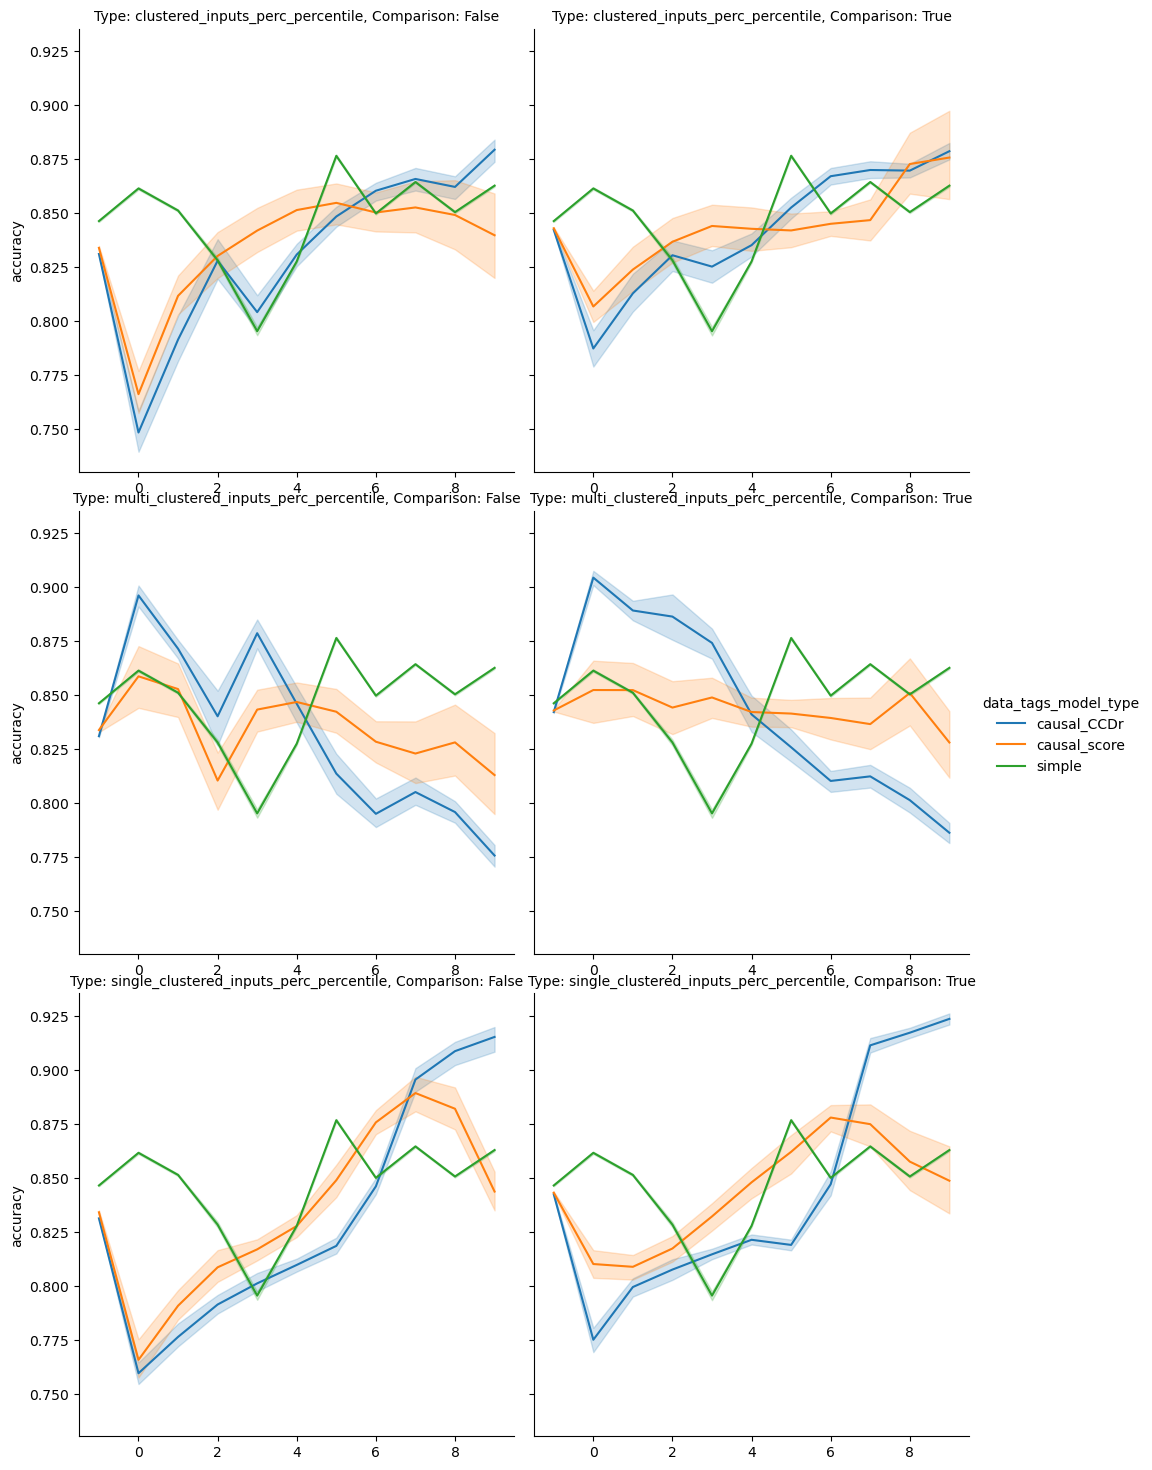

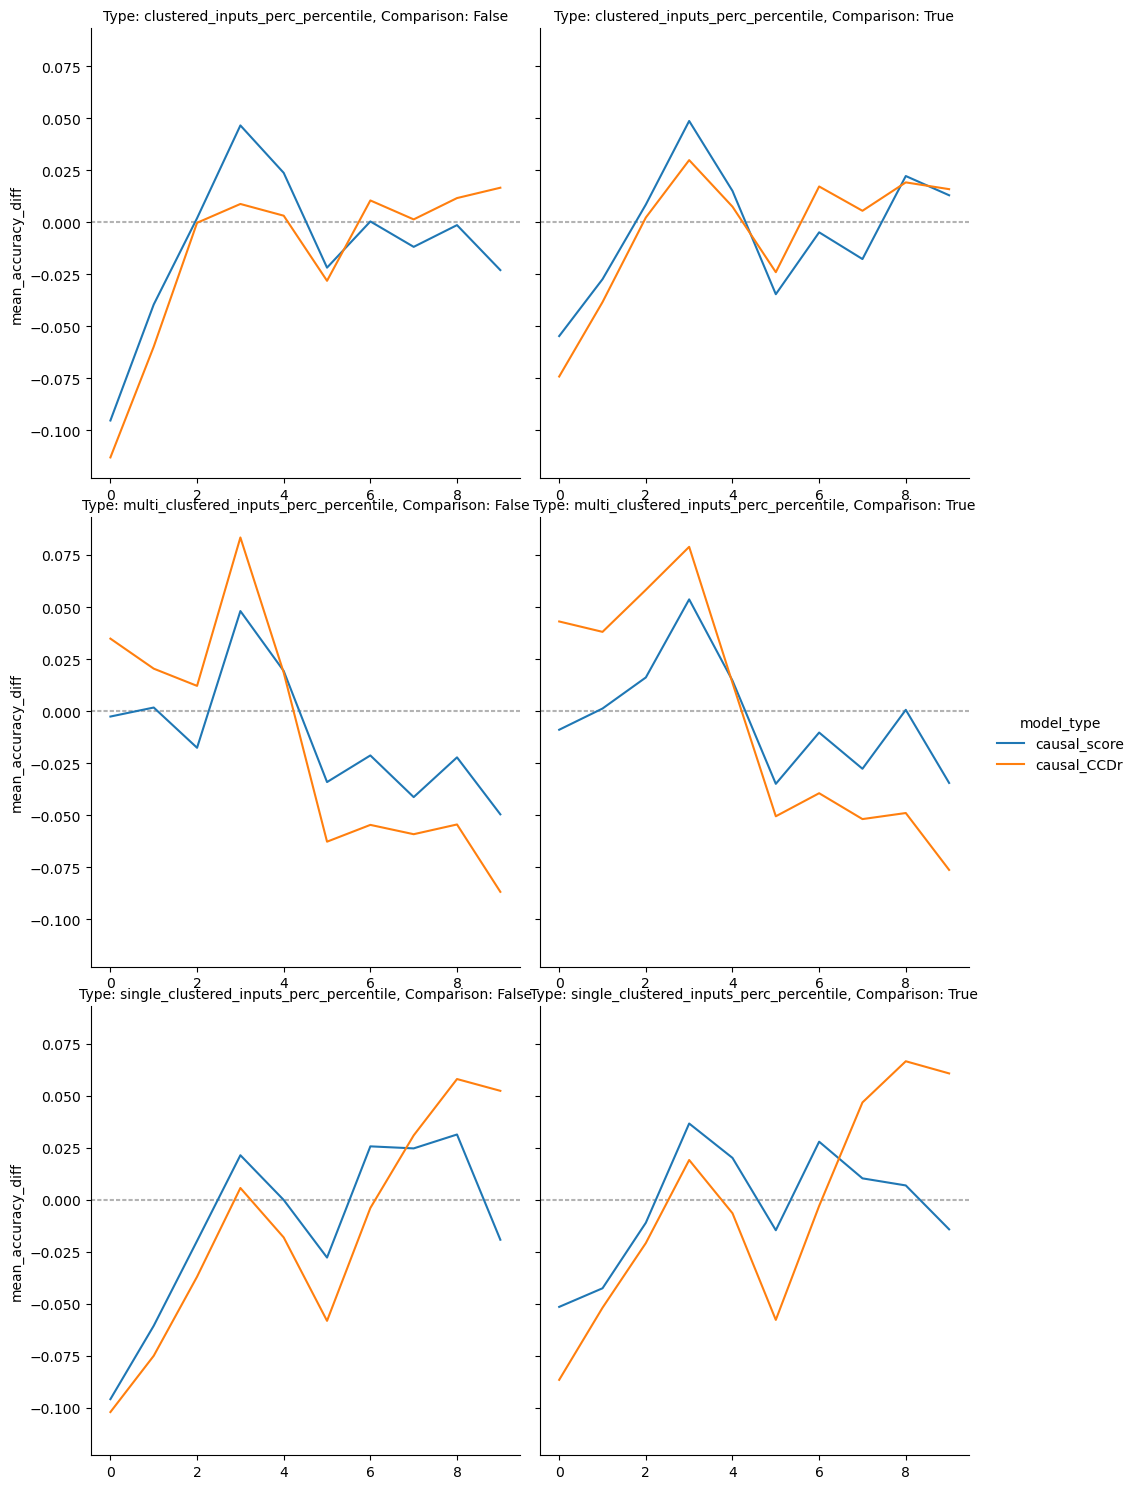

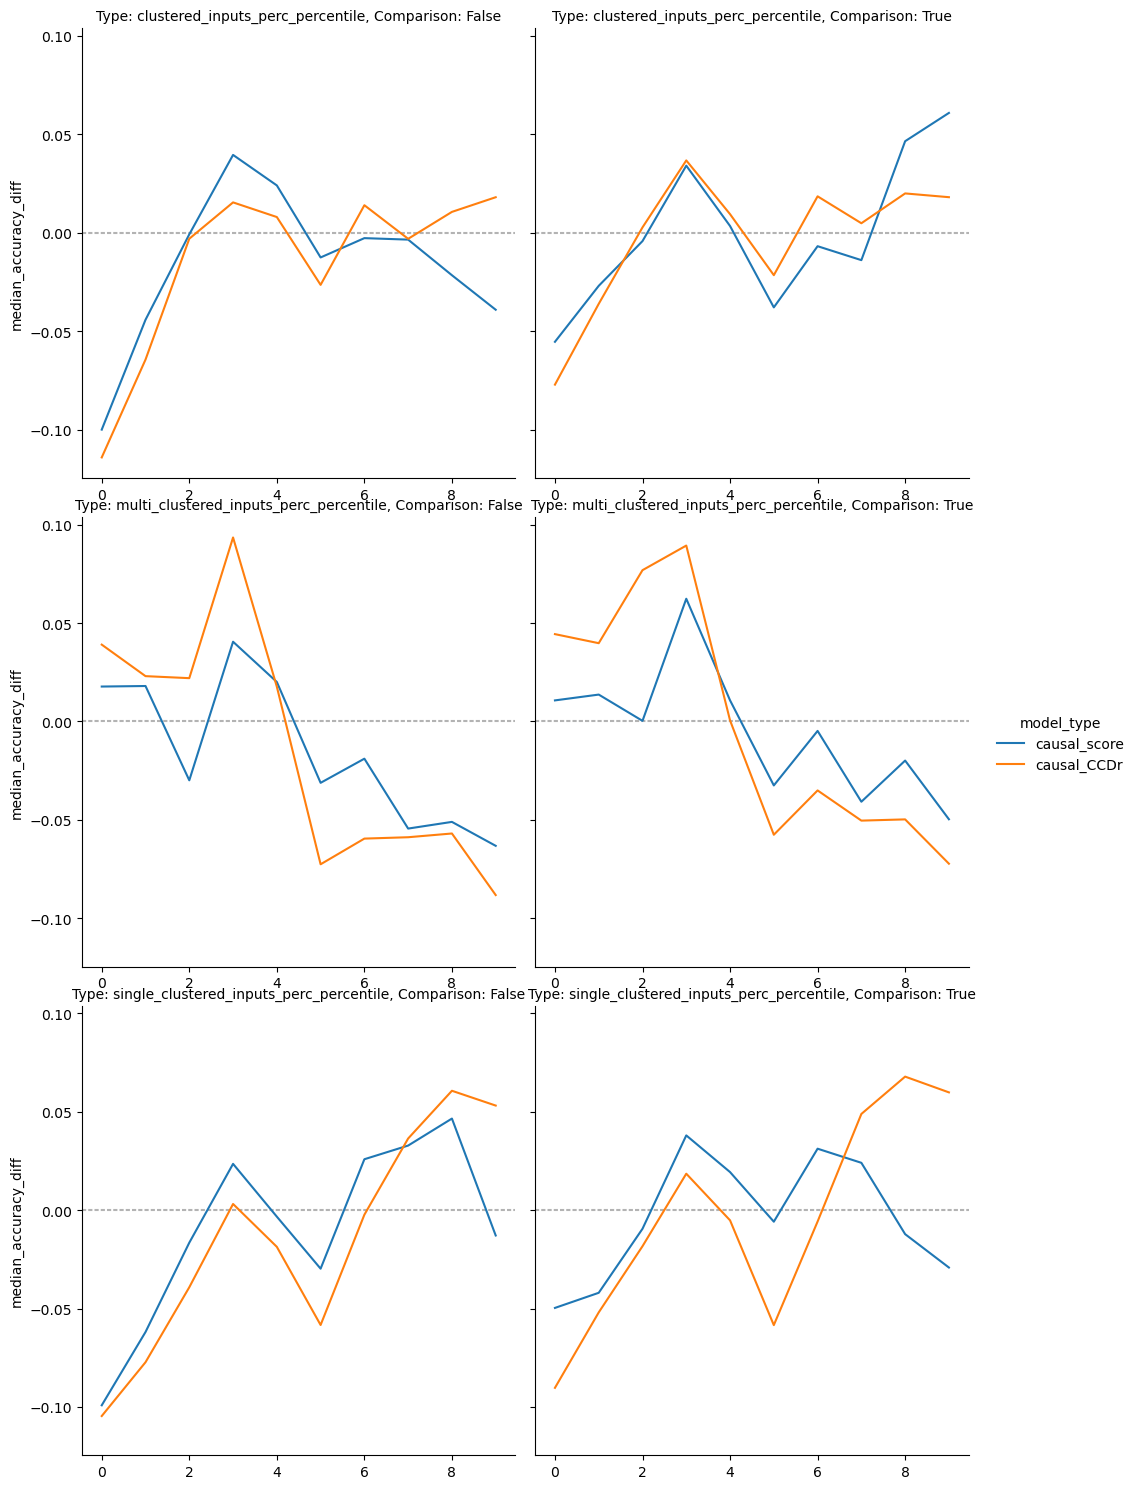

In [12]:
plot_accuracies_per_percentiles(
    relevant_run_df=relevant_run_df, 
    accuracy_df=accuracy_df[
        accuracy_df["type"].apply(lambda x: x in [
            "clustered_inputs_perc_percentile",
            "single_clustered_inputs_perc_percentile",
            "multi_clustered_inputs_perc_percentile"
        ])    
    ],
    show_plot=True,
    share_y=True,
    comparison_column="data_params_HuaweiPreprocessorConfigremove_dates_from_payload",
    algorithm_types=["causal_score", "causal_CCDr"]
)